## Neural Networks face mask detection model

I built a model that classifies a person face into 3 output classes of with mask, without mask, and mask weared incorrect.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing
import the image dataset using image_dataset_from_directory method.

Image dataset collected from the kaggle provided 8982 images with image size of 128.

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 12
CHANNELS = 3
EPOCHS=5

I used keras preprocessing library to split the dataset into train,test,validation dataset and to have them labelled as folder names.

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Neural_Networks/Dataset/face_mask',
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
    )

Found 8982 files belonging to 3 classes.


Checked the shape of the image dataset from batch 1 to ensure that the dataset was imported correctly.

In [6]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)

(12, 128, 128, 3)


Setting class names from the dataset object created using tf.keras.preprocessing library.

In [7]:
class_names = dataset.class_names

In [8]:
class_names

['mask_weared_incorrect', 'with_mask', 'without_mask']

Plotting the first batch of image dataset with actual labels

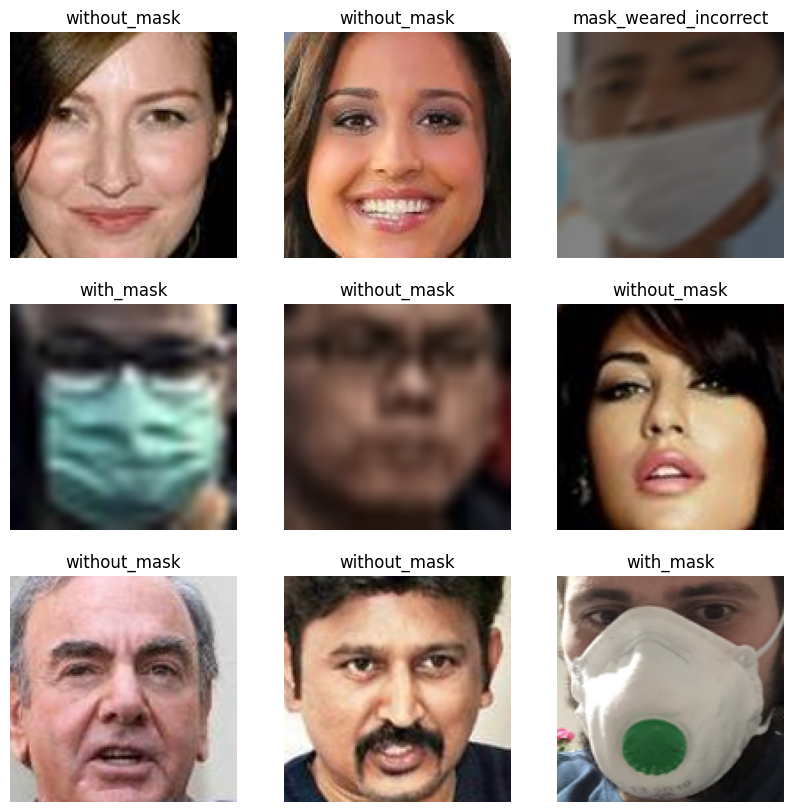

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

    plt.axis('off')

Split the dataset into 70% training and 20% testing and 10% validation after each epoch

In [10]:
def split_dataset(dataset,train_split=0.7,val_split=0.1,test_split=0.2,shuffle=True,shuffle_size=8000):
  ds_size = len(dataset)

  if shuffle:
    dataset=dataset.shuffle(shuffle_size,seed=23)

  train_size = int(len(dataset)*train_split)
  test_size = int(len(dataset)*test_split)
  val_size = int(len(dataset)*val_split)

  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = split_dataset(dataset)

First batch image dataset output shows the tensor converted version of the image dataset, describing the shape and type.

In [12]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
rescale = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.0),
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE)
])

## Build Model

I built the model first using an augmentation layers coded above, and added convolutional layer and maxpooling layer each of 2. Then added flattening layer another dense layer with relu activation function. Lastly, I added a Dense output layer with 3 neurons since the image dataset has 3 classes.

In [14]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes = len(class_names)

In [15]:
CNN = models.Sequential([
    rescale,
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

CNN.build(input_shape=input_shape)

In [16]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (12, 126, 126, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (12, 63, 63, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (12, 61, 61, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (12, 30, 30, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (12, 57600)              

compile the model

In [17]:
CNN.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

train the model and store the training history

In [18]:
history = CNN.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/5
524/524 [==============================] - 157s 13ms/step - loss: 0.3234 - accuracy: 0.8741 - val_loss: 0.1704 - val_accuracy: 0.9381
Epoch 2/5
524/524 [==============================] - 11s 13ms/step - loss: 0.1703 - accuracy: 0.9424 - val_loss: 0.0813 - val_accuracy: 0.9673
Epoch 3/5
524/524 [==============================] - 11s 12ms/step - loss: 0.1184 - accuracy: 0.9612 - val_loss: 0.0824 - val_accuracy: 0.9718
Epoch 4/5
524/524 [==============================] - 10s 12ms/step - loss: 0.0845 - accuracy: 0.9723 - val_loss: 0.0552 - val_accuracy: 0.9786
Epoch 5/5
524/524 [==============================] - 10s 12ms/step - loss: 0.0548 - accuracy: 0.9806 - val_loss: 0.0445 - val_accuracy: 0.9854


In [19]:
scores = CNN.evaluate(test_ds)

151/151 [==============================] - 5s 3ms/step - loss: 0.0290 - accuracy: 0.9890


## Conclusion

The overall model accuracy gave 0.99 of high accuracy and we can say that it gives pretty accurate classification results. However, I will need to collect more mask image data to make the model flexible to have more various inputs.